In [1]:
#Import Libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os #operating system dependent modules of Python
import matplotlib.pyplot as plt #visualization
import seaborn as sns #visualization
%matplotlib inline
import itertools
import plotly.offline as py #visualization
py.init_notebook_mode(connected=True) #visualization
import plotly.graph_objs as go #visualization
import warnings
warnings.filterwarnings("ignore")

In [2]:
nyc_data = pd.read_csv("/Users/manting/Desktop/NYCtaxi/train.csv", nrows = 5000000)
nyc_data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [3]:
#replace 0's in coordinates with null values
coord = ['pickup_longitude','pickup_latitude', 
         'dropoff_longitude', 'dropoff_latitude']

for i in coord :
    nyc_data[i] = nyc_data[i].replace(0,np.nan)
    nyc_data    = nyc_data[nyc_data[i].notnull()]

#conver to date format
nyc_data["pickup_datetime"] = nyc_data["pickup_datetime"].astype(str).str.replace(" UTC","")
nyc_data["pickup_datetime"] = pd.to_datetime(nyc_data["pickup_datetime"],
                                             format="%Y-%m-%d %H:%M:%S")
#extract year
nyc_data["year"]  = pd.DatetimeIndex(nyc_data["pickup_datetime"]).year
#extract month
nyc_data["month"] = pd.DatetimeIndex(nyc_data["pickup_datetime"]).month
nyc_data["month_name"] = nyc_data["month"].map({1:"JAN",2:"FEB",3:"MAR",
                                                4:"APR",5:"MAY",6:"JUN",
                                                7:"JUL",8:"AUG",9:"SEP",
                                                10:"OCT",11:"NOV",12:"DEC"
                                               })
#merge year month
nyc_data["month_year"] = nyc_data["year"].astype(str) + " - " + nyc_data["month_name"]
#extract day 
nyc_data["day"]        = nyc_data["pickup_datetime"].dt.day
#extract hour
nyc_data["hour"]        = nyc_data["pickup_datetime"].dt.hour 
nyc_data = nyc_data.sort_values(by = "pickup_datetime",ascending = False)

#Outlier treatment
#drop observations with passengers greater than 6 and equals 0
nyc_data = nyc_data[(nyc_data["passenger_count"] > 0 ) &
                    (nyc_data["passenger_count"] < 7) ]

#drop observations with fareamount  less than 0 and  greater than 99.99% percentile value.
nyc_data = nyc_data[ (nyc_data["fare_amount"] > 0 ) &
                     (nyc_data["fare_amount"]  <  
                      nyc_data["fare_amount"].quantile(.9999))]

#drop outlier observations in data
coords = ['pickup_longitude','pickup_latitude', 
          'dropoff_longitude', 'dropoff_latitude']
for i in coord  : 
    nyc_data = nyc_data[(nyc_data[i]   > nyc_data[i].quantile(.001)) & 
                        (nyc_data[i] < nyc_data[i].quantile(.999))]
    
nyc_data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,month_name,month_year,day,hour
2203030,2015-06-30 23:59:03.0000004,11.0,2015-06-30 23:59:03,-73.969475,40.750282,-73.993965,40.751568,1,2015,6,JUN,2015 - JUN,30,23
2031461,2015-06-30 23:56:50.0000001,14.5,2015-06-30 23:56:50,-73.992104,40.734531,-73.960335,40.775703,1,2015,6,JUN,2015 - JUN,30,23
3088533,2015-06-30 23:56:00.0000001,20.0,2015-06-30 23:56:00,-73.970154,40.757011,-73.962608,40.708641,1,2015,6,JUN,2015 - JUN,30,23
3211962,2015-06-30 23:55:51.0000007,6.5,2015-06-30 23:55:51,-74.010147,40.720520,-74.000557,40.727139,1,2015,6,JUN,2015 - JUN,30,23
785182,2015-06-30 23:53:49.0000003,7.5,2015-06-30 23:53:49,-73.959969,40.762405,-73.953064,40.782688,1,2015,6,JUN,2015 - JUN,30,23


#Finding distance based on longitude and latitude

The Haversine formula determines the great-circle distance between two points on a sphere given their longitudes and latitudes.

dlon = dropoff_lon - pickup_lon

dlat = dropoff_lat - pickup_lat

a = (sin(dlat/2))^2 + cos(dropoff_lat) * cos(pickup_lat) * (sin(dlon/2))^2

c = 2 * atan2(sqrt(a), sqrt(1-a))

d = R * c (where R is the radius of the Earth)

In [4]:
#radius of earth in kilometers
R = 6373.0

pickup_lat  = np.radians(nyc_data["pickup_latitude"])
pickup_lon  = np.radians(nyc_data["pickup_longitude"])
dropoff_lat = np.radians(nyc_data["dropoff_latitude"])
dropoff_lon = np.radians(nyc_data["dropoff_longitude"])

dist_lon = dropoff_lon - pickup_lon
dist_lat = dropoff_lat - pickup_lat

#Formula
a = (np.sin(dist_lat/2))**2 + np.cos(pickup_lat) * np.cos(dropoff_lat) * (np.sin(dist_lon/2))**2 
c = 2 * np.arctan2( np.sqrt(a), np.sqrt(1-a) ) 
d = R * c #(where R is the radius of the Earth)

nyc_data["trip_distance_km"] = d

#create new variable log of distance
nyc_data["log_trip_ditance"] = np.log(nyc_data["trip_distance_km"])

nyc_data[coord + ["trip_distance_km"]].head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_distance_km
2203030,-73.969475,40.750282,-73.993965,40.751568,2.068571
2031461,-73.992104,40.734531,-73.960335,40.775703,5.304466
3088533,-73.970154,40.757011,-73.962608,40.708641,5.417685
3211962,-74.010147,40.720520,-74.000557,40.727139,1.093388
785182,-73.959969,40.762405,-73.953064,40.782688,2.329810


Distribution of Haversine Distance in Kilometers

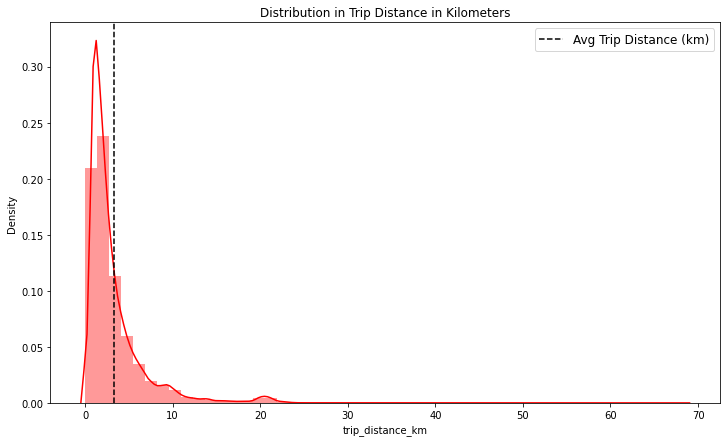

In [5]:
plt.figure(figsize = (12,7))
sns.distplot(nyc_data["trip_distance_km"],color = "r")
plt.axvline(nyc_data["trip_distance_km"].mean(),color = "k",
            linestyle = "dashed",label = "Avg Trip Distance (km)")
plt.title("Distribution in Trip Distance in Kilometers")
plt.legend(loc = "best",prop = {"size" : 12})
plt.show()

Total Trips, Passengers and Fare Amount per Year

In [6]:
yearly_analysis  = nyc_data.groupby("year").agg({"key":"count",
                                                 "fare_amount":"sum",
                                                 "passenger_count":"sum",
                                                 "trip_distance_km" : "sum"}).reset_index()
#aggregating by year
yearly_analysis = yearly_analysis.rename(columns = {"key" : "trip_count"})

#plotting trips ,passengers and fare amount by year
def plotting(column) : 
    tracer = go.Bar(x= yearly_analysis["year"],y = yearly_analysis[column],
                    marker = dict(line = dict(width = 1)),
                    name = column
                   )
    return tracer

#layout
layout = go.Layout(dict(title = "Total trips, Passengers, Distance and Fare Amount per Year",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',title = "Year",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',title = "Count",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                       )
                  )
    
data = [plotting("trip_count"),plotting("passenger_count"),
        plotting("trip_distance_km"),plotting("fare_amount")]
fig  = go.Figure(data=data,layout=layout)
py.iplot(fig)

Trend in Trips by Hour of Day

In [7]:
trips_hr = nyc_data["hour"].value_counts().reset_index()
trips_hr.columns = ["hour","count"]
trips_hr = trips_hr.sort_values(by = "hour",ascending = True)

trace = go.Scatter(x = trips_hr["hour"],y = trips_hr["count"],
                   mode = "markers+lines",
                  marker = dict(color = "red",size = 9,
                                line = dict(color = "black",width =2)))
#layout
layout = go.Layout(dict(title = "Trend in Trips by Hour of Day",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',title = "Hour",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',title = "Count",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                       )
                  )

fig = go.Figure(data = [trace],layout = layout)
py.iplot(fig)